C:\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0353 - val_loss: 6.7183e-04
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0021 - val_loss: 8.1529e-04
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016 - val_loss: 7.8884e-04
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015 - val_loss: 6.8751e-04
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - val_loss: 5.6608e-04
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015 - val_loss: 4.7360e-04
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014 - val_loss: 4.4973e-04
Epoch 8/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014 - val_loss: 4.5904e-04
Epoch 9/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013 - val_loss: 7.0697e-04
Epoch 10/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012 - val_loss: 4.3742e-04
Epoch 11/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - val_loss: 4.3566e-04
Epoch 1

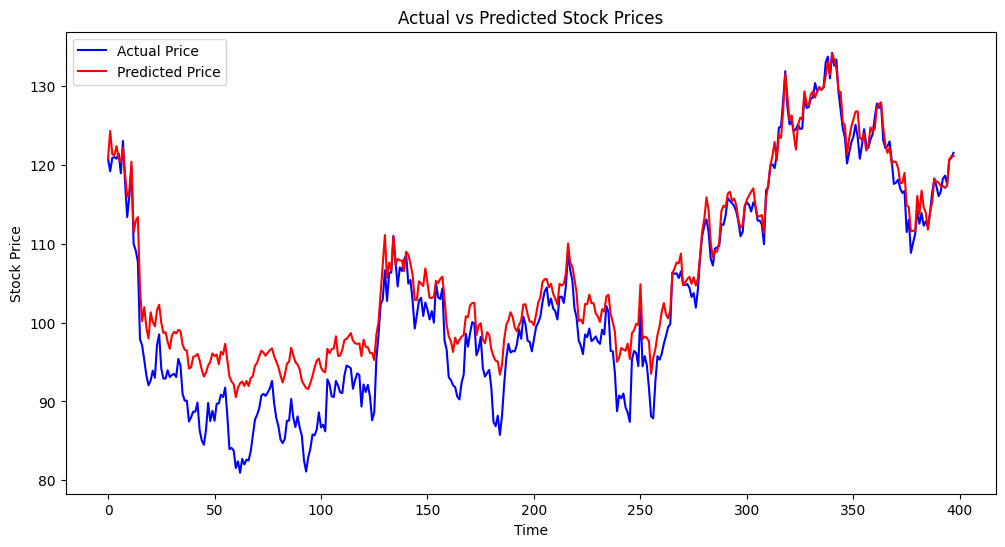

Prediction Complete.


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Load Stock Data
def load_stock_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

# Step 2: Feature Engineering
def create_features(df):
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()
    df['Momentum'] = df['Close'].diff(5)
    df['Volatility'] = df['Close'].rolling(window=10).std()
    df.dropna(inplace=True)
    return df

# Step 3: Prepare Data for BiLSTM
def prepare_data(df):
    feature_cols = ['SMA_10', 'SMA_50', 'EMA_10', 'EMA_50', 'Momentum', 'Volatility']
    X = df[feature_cols].values
    y = df['Close'].values
    
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    
    train_size = int(0.8 * len(X))
    X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
    y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, X_test, y_train, y_test, scaler_X, scaler_y, y

# Step 4: Build BiLSTM Model
def build_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape),
        Dropout(0.2),
        Bidirectional(LSTM(50, return_sequences=False)),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Step 5: Train and Predict using BiLSTM
def train_predict_bilstm(X_train, X_test, y_train, y_test, scaler_y):
    model = build_bilstm_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    
    predictions = model.predict(X_test)
    predictions = scaler_y.inverse_transform(predictions)
    y_actual = scaler_y.inverse_transform(y_test)
    
    mse = mean_squared_error(y_actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_actual, predictions)
    r2 = r2_score(y_actual, predictions)
    
    print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_actual, label='Actual Price', color='blue')
    plt.plot(predictions, label='Predicted Price', color='red')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title('Actual vs Predicted Stock Prices')
    plt.legend()
    plt.show()
    
    return model, predictions

# Main Execution
if __name__ == "__main__":
    file_path = 'NSE-TATAGLOBAL.csv'
    df = load_stock_data(file_path)
    df = create_features(df)
    X_train, X_test, y_train, y_test, scaler_X, scaler_y, y_actual = prepare_data(df)
    model, predictions = train_predict_bilstm(X_train, X_test, y_train, y_test, scaler_y)
    
    print("Prediction Complete.")
